# What is a Process and a Thread. What are the differences?

A **process** is an instance of program (e.g. Jupyter notebook, Python interpreter). Processes spawn **threads** (sub-processes) to handle subtasks like reading keystrokes, loading HTML pages, saving files. Threads live inside processes and share the same memory space.

**Example: Microsoft Word**<br>
When you open **Word**, you create a process. When you start typing, the process spawns threads: one to read keystrokes, another to display text, one to autosave your file, and yet another to highlight spelling mistakes. By spawning multiple threads, Microsoft takes advantage of idle CPU time (waiting for keystrokes or files to load) and makes you more productive. See it like this: When one thread is waiting for key stroke, another thread is auto-saving while one other thread is displaying spelling error.

Process
* Created by the operating system to run programs
* Processes can have multiple threads
* Two processes can execute code simultaneously in the same python program
* Processes have more overhead than threads as opening and closing processes takes more time
* Sharing information between processes is slower than sharing between threads as processes do not share memory space. In python they share information by pickling data structures like arrays which requires IO time.

Thread
* Threads are like mini-processes that live inside a process
* They share memory space and efficiently read and write to the same variables
* Two threads cannot execute code simultaneously in the same python program (although there are workarounds)

# Are Multiprocessing and Multithreading basically same things in Python : No

We will understand this with code and plots

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor


# Both these functions will call the function "func" for each of the arguments in the iterator "args". 
# All the functions (copies of "func" fuction) will be executed on either different 
# threads(in case of multi-threading) or processes (in case of multiprocessing).
def multithreading(func, args, workers):
    with ThreadPoolExecutor(workers) as ex:
        res = ex.map(func, args)
    return list(res)


def multiprocessing(func, args, workers):
    with ProcessPoolExecutor(workers) as ex:
        res = ex.map(func, args)
    return list(res)


# This is a dummy function which is somewhat CPU heavy. we will execute 
# it many times using both multi-threading and multi-processing
def cpu_heavy(x):
    print('I am', x)
    start = time.time()
    count = 0
    for i in range(10**4):
        count += i
    stop = time.time()
    return start, stop


def visualize_runtimes(results, title):
    start, stop = np.array(results).T
    plt.barh(range(len(start)), stop - start)
    plt.grid(axis='x')
    plt.ylabel("Tasks")
    plt.xlabel("Seconds")
    plt.xlim(0, 22.5)
    ytks = range(len(results))
    plt.yticks(ytks, ['job {}'.format(exp) for exp in ytks])
    plt.title(title)
    return stop[-1] - start[0]


print("Multithreading")
plt.subplot(1, 2, 1)
visualize_runtimes(multithreading(cpu_heavy, range(4), 4), "Multithreading")
print("Multiprocessing")
plt.subplot(1, 2, 2)
visualize_runtimes(multiprocessing(cpu_heavy, range(4), 4), "Multiprocessing")
plt.show()

ModuleNotFoundError: No module named 'matplotlib'

This plot shows that in case of Multithreading, all the jobs had different time of finish. Whereas in Multiprocessing all of them finished around the same time.


As expected **Multi-processing is much faster than Multi-threading**. While Multithreading took around 20 seconds, Multiprocessing took much less time.


Also note that the print statement in the case of Multi-processing can be jumbeled. This indicates that out of all the processes any one of them can give output to screen first. In case of Multi-threading the outputs can be out of order showing that threads are stopped in between and than started after execution of another thread.

# Difference between Multiprocessing and Multithreading.

First let us understand difference between **concurrency** and **parallelism**.

Concurrency and parallelism are related terms but not the same, and often misconceived as the similar terms. The crucial difference between concurrency and parallelism is that concurrency is about dealing with a lot of things at same time (gives the illusion of simultaneity) or handling concurrent events essentially hiding latency. On the contrary, parallelism is about doing a lot of things at the same time for increasing the speed.

Now back to **Multiprocessing** and **Multithreading**.

In case of Multithreading, threads neither run in parallel nor in sequence. They run concurrently! Each time one job is executed a little and then the other takes on.

Whereas, in case of Multiprocessing actual parallel excecution is taking place and thus enhanced speed.

**Let's see that with code to explain better.**

Multithreading
I amI am 1
I am 2
 0
I am 3
Multiprocessing
I am 0
I am 1
I am 2
I am 3


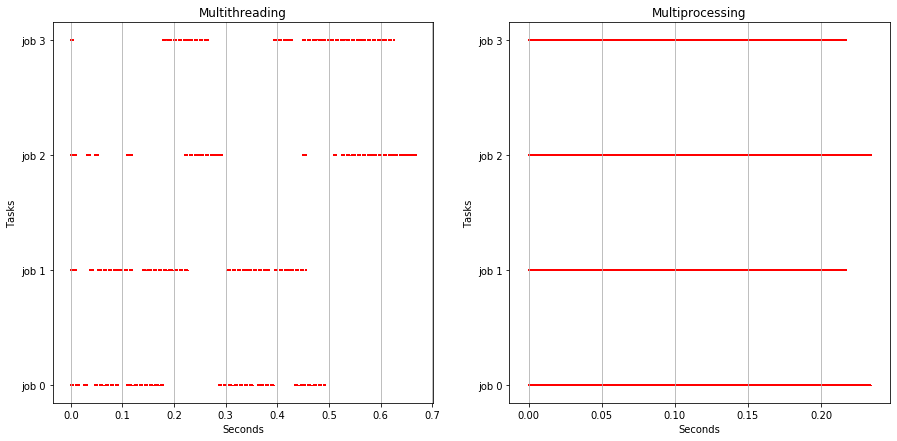

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 7

# We have changed only these two functions, rest all will be same as above

def live_tracker(x):
    print('I am', x)
    reference = time.time()
    l = []
    for i in range(10**6):
        l.append(time.time() - reference)
    return l


def visualize_live_runtimes(results, title):
    for i, exp in enumerate(results):
        plt.scatter(exp, np.ones(len(exp)) * i, alpha=0.8, c='red', edgecolors='none', s=1)

    plt.grid(axis='x')
    plt.ylabel("Tasks")
    ytks = range(len(results))
    plt.yticks(ytks, ['job {}'.format(exp) for exp in ytks])
    plt.xlabel("Seconds")
    plt.title(title)


print("Multithreading")
plt.subplot(1, 2, 1)
visualize_live_runtimes(multithreading(live_tracker, range(4), 4), "Multithreading")
print("Multiprocessing")
plt.subplot(1, 2, 2)
visualize_live_runtimes(multiprocessing(live_tracker, range(4), 4), "Multiprocessing")
plt.show()

As you can see, in case of multithreading the jobs are executed concurrently whereas in the case of multiprocessing there is continuous paraller excecution.

So if you have a cpu heavy task, and you want to make it faster use multiprocessing!
For example if you have 4 cores, with multithreading each core will be at around 25% capacity while with multiprocessing you will get 100% on each core. This means that with 100% on 4 cores you will get a speedup by 4.

# Why Multi-threading doesn't help in Python like other languages?

This is because of GIL (Global Interpreter Lock). Because of some memory management [reasons](https://realpython.com/python-gil), GIL was used to avoid conflict when dealing with multiple threads. 

In python when a thread wants access to the interpreter it has to get hold of GIL which it receives only when its free and not used by any other thread. So in assence, at any given point in time only one thread can get access to the interpreter. 

And thus we have a plot like above.

# Where can we use Multi-threading?

In **IO tasks**.

I/O-bound programs are the ones that spend time waiting for Input/Output which can come from a user, file, database, network, etc. 
I/O-bound programs sometimes have to wait for a significant amount of time till they get what they need from the source due to the fact that the source may need to do its own processing before the input/output is ready, for example, a user thinking about what to enter into an input prompt or a database query running in its own process.

In [ ]:
import urllib.request


urls = ['http://www.discovertunisia.com',
        'http://whc.unesco.org/en/list/38',
        'https://www.youtube.com/watch?v=sHORcz5nqIc',
        'https://www.youtube.com/watch?v=dyHjCwKoNn8'
        'http://www.tourismtunisia.com/10-adventurous-things-to-do-in-tunisia/',
        'http://wowtravel.me/top-10-things-to-do-in-tunisia/',
        'http://en.wikipedia.org/wiki/Tataouine',
        'http://en.wikipedia.org/wiki/Carthage',
        'http://en.wikipedia.org/wiki/Hannibal',
        'http://www.discovertunisia.com',
        'http://whc.unesco.org/en/list/38',
        'https://www.youtube.com/watch?v=sHORcz5nqIc',
        'https://www.youtube.com/watch?v=dyHjCwKoNn8'
        'http://www.tourismtunisia.com/10-adventurous-things-to-do-in-tunisia/',
        'http://wowtravel.me/top-10-things-to-do-in-tunisia/',
        'http://en.wikipedia.org/wiki/Tataouine',
        'http://en.wikipedia.org/wiki/Carthage',
        'http://en.wikipedia.org/wiki/Hannibal'
        ]


def load_url(x):
    with urllib.request.urlopen(urls[x], timeout=20) as conn:
        return conn.read()


n_jobs = len(urls)


marker = time.time()
for i in range(n_jobs): load_url(i)
print("Time take by Serial execution: ", time.time() - marker)


for n_threads in [4, 8, 16]:
    marker = time.time()
    multithreading(load_url, range(n_jobs), n_threads)
    print(f"Time taken by Multithreading with {n_threads} threads: {time.time() - marker}")

Time take by Serial execution:  21.34294080734253
Time taken by Multithreading with 4 threads: 6.35723352432251
Time taken by Multithreading with 8 threads: 3.400176525115967
Time taken by Multithreading with 16 threads: 6.63349723815918


Now as you can see, with number of threads increasing, the time taken for IO tasks has reduced significantly.

Notice we have we have gained a significant speedup with multithreading in comparaison to serial! Note also that the more threads you have, the faster your execution. Of course there is no point of having more threads than the number of urls, this is why we stopped at 16 threads for 16 urls.

# When to use Multithreading and Multiprocessing?

* **Processes** speed up Python operations that are CPU intensive because they benefit from multiple cores and avoid the GIL. So **in CPU intensive tasks, Multiprocessing is recommended.**
* **Threads** are best for IO tasks or tasks involving external systems because threads can combine their work more efficiently. Processes need to pickle their results to combine them which takes time. Threads provide no benefit in python for CPU intensive tasks because of the GIL. Thus **for IO tasks using Multithreading would be a good choice.**

# Conclusion

* There can only be one thread running at any given time in a python process.
* Multiprocessing is parallelism. Multithreading is concurrency.
* Multiprocessing is for increasing speed. Multithreading is for hiding latency.
* Multiprocessing is best for computations. Multithreading is best for IO.
* If you have CPU heavy tasks, use multiprocessing with n_process = n_cores and never more. Never!
* If you have IO heavy tasks, use multithreading with n_threads = m * n_cores with m a number bigger than 1 that you can tweak.

# References

* [Multithreading VS Multiprocessing in Python](https://medium.com/contentsquare-engineering-blog/multithreading-vs-multiprocessing-in-python-ece023ad55a)
* [What is the Python Global Interpreter Lock](https://realpython.com/python-gil)
* [Intro to Threads and Processes in Python](https://medium.com/@bfortuner/python-multithreading-vs-multiprocessing-73072ce5600b)